# Mesa Tutorial - Forest Fire Model

![ForestFire](ForestFire.png)

### Indice
1. Modelo e Agentes
2. Tempo (Scheduling)
3. Espaço
4. Data Collection
5. Visualização e Parametrização
6. Possíveis Integrações

In [1]:
import random

#1. Modelo e Agentes
from mesa import Model, Agent

#2. Espaço
from mesa.space import Grid

#3. Tempo (Scheduling)
from mesa.time import RandomActivation

#4. Data Collection
from mesa.datacollection import DataCollector

#5. Visualização e Parametrização
from mesa.visualization.modules import CanvasGrid, ChartModule
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.UserParam import UserSettableParameter

#6 Possíveis Integrações
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt 


## Classe Agent
**\_\_init\_\_**(unique_id, model) - *Construtor*

**step**()

In [2]:
class Tree(Agent):

    def __init__(self, pos, model):

        super().__init__(pos, model)
        
        self.pos = pos # Coordenadas (X,Y)
        self.condition = "Fine" #Either "Fine", "On Fire" or "Burned Out"

    def step(self):

        if self.condition == "On Fire":
            
            for neighbor in self.model.grid.neighbor_iter(self.pos):
                if neighbor.condition == "Fine":
                    neighbor.condition = "On Fire"
                    
            self.condition = "Burned Out"

    def get_position(self):
        return self.pos

## Classe Model
**\_\_init\_\_**() - *Construtor*
* self.running = True
* self.schedule = None
* self.current_id = 0

**step**()

**run_model**() - *Corre o modelo até chegar a uma condição de paragem.*

**reset_randomize**(seed) - *Opcional*

## Espaço

### **Tipos:**
* **Grid** - Grid quadrangular.
* **MultiGrid** - Grid cujas células podem conter mais do que um agente.
* **HexGrid** - Grid hexagonal.
* **ContinuousSpace** - Agentes ocupam pontos arbitrários no espaço.
* **NetworkGrid** - Rede em que cada nó pode zero ou mais agentes.

...

* *NetworkX* ou *Graph-tool* para grafos

* Outras bibliotecas para 3D

### **Funções principais:**

**place_agent**(Agent, Coordinate)

**remove_agent**(Agent)

**move_to_empty**(Agent)

**is_cell_empty**(Coordinate)

...

## Tempo (Scheduler)

**Scheduler** é um objeto que serve para gerir a componente temporal do modelo e a forma como são ativados os agentes.

### **Tipos:**
* **BaseScheduler** - Ativa cada agente uma vez por step, pelo ordem em que foram adicionados.
* **RandomActivation** - Ativa cada agente uma vez por step, em ordem aleatória (a ordem altera-se a cada step). Semelhante ao *ask agents* do NetLogo.
* **SimultaneousActivation** - Simula a ativação simultânea de todos os agentes. Implica a utilização do step() e do advance(). A primeira função ativa o agente e prepara as alterações necessárias, a segunda função aplica as alterações.
* **StagedActivation**(stage_list) - Permite que a ativação dos agentes seja dividida em várias etapas. Os agentes devem ter funções para todas as etapas. Recebe uma lista das etapas como parâmetro.

### **Funções principais:**

**add**(agent)

**remove**(agent)

**step**()

## DataCollector
Objeto coletor de dados do modelo.

1. É inicializado com um dicionário que emparelha os nomes dos dados com os **atributos ou funções (reporters)** que produzem esses mesmos dados.
2. É chamada a função **collect()** ao fim de cada step, que executará os reporters.

In [3]:
class ForestFire(Model):
    
    def __init__(self, height, width, density):
        # Parâmetros do modelo
        self.height = height
        self.width = width
        self.density = density
        
        # Scheduler e Grid
        self.schedule = RandomActivation(self)
        self.grid = Grid(height, width, torus=False)

        # Place a tree in each cell with Prob = density
        for (contents, x, y) in self.grid.coord_iter():
            if random.random() < self.density:
                # Create a tree
                new_tree = Tree((x, y), self)
                # Set all trees in the first column on fire.
                if x == 0:
                    new_tree.condition = "On Fire"
                self.grid._place_agent((x, y), new_tree)
                self.schedule.add(new_tree)
        self.running = True
        
        
        # Data Collector
        self.datacollector = DataCollector(
            {"Fine": lambda m: self.count_type(m, "Fine"),
             "On Fire": lambda m: self.count_type(m, "On Fire"),
             "Burned Out": lambda m: self.count_type(m, "Burned Out")})

    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)

        # Condição de Paragem
        if self.count_type(self, "On Fire") == 0:
            self.running = False

    @staticmethod
    def count_type(model, tree_condition):
        count = 0
        for tree in model.schedule.agents:
            if tree.condition == tree_condition:
                count += 1
        return count

In [4]:
myModel = ForestFire(100, 100, 0.7)

myModel.run_model()
    
df = myModel.datacollector.get_model_vars_dataframe()

df

,Fine,On Fire,Burned Out
0,6659,148,206
1,6386,142,485
2,6110,149,754
3,5812,160,1041
4,5550,137,1326
5,5322,127,1564
6,5036,142,1835
7,4799,134,2080
8,4617,103,2293
9,4405,116,2492


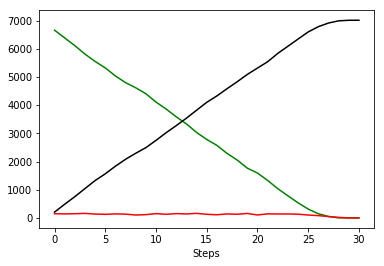

In [5]:
plt.plot(df['Fine'], label = "Fine", color = 'g')
plt.plot(df['On Fire'], label = "Fine", color = 'r')
plt.plot(df['Burned Out'], label = "Fine", color = 'k')
plt.xlabel("Steps")
plt.show()

## Visualização (ModularServer)

**ModularServer**(Modelo, [Módulos], Nome_do_Modelo, Parametros_do_Modelo)

launch()

### Módulos:
* **CanvasGrid**(portrayal_method, grid_height, grid_width, canvas_height, canvas_width)
* HexGrid
* Network


* Chart
* PieChart
* BarChart
* Text

Alguns módulos requerem um portrayal, ou seja, um dicionário com os seguintes elementos:
* **"x", "y"**
* **"Shape"**: "circle", "rect", "arrowHead" ou imagem
* **"Color"**
* **"Filled"**
* **"Layer"**
* **"text"**
* **"text_color"**

### Parâmetros:
Dicionário com o nome dos parâmetros e os seus valores iniciais, ou objeto **UserSettableParameter**.

**Tipos de UserSettableParameter:**
* number
* checkbox
* choice
* slider

In [6]:
def forest_fire_portrayal(tree):
    if tree is None:
        return
    portrayal = {"Shape": "rect", "w": 1, "h": 1, "Filled": "true", "Layer": 0}
    
    (x, y) = tree.get_position()
    portrayal["x"] = x
    portrayal["y"] = y
    
    colors = {"Fine": "#00AA00",
              "On Fire": "#880000",
              "Burned Out": "#000000"}
    portrayal["Color"] = colors[tree.condition]
    
    return portrayal

canvas_element = CanvasGrid(forest_fire_portrayal, 100, 100, 500, 500)

chart_element = ChartModule([{"Label": "Fine", "Color": "green"},
                             {"Label": "On Fire", "Color": "red"},
                             {"Label": "Burned Out", "Color": "black"}])

model_parameters = {
        "density": UserSettableParameter(
        "slider", "Forest Density",  value=0.6, min_value=0, max_value=1, step=0.01
        ),
        "height": 100,
        "width": 100
}

server = ModularServer(ForestFire, [canvas_element, chart_element], "Forest Fire", model_parameters)


In [7]:
server.launch()

Interface starting at http://127.0.0.1:8521


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
{"type":"submit_params","param":"density","value":0.58}
{"type":"submit_params","param":"density","value":0.57}
{"type":"submit_params","param":"density","value":0.56}
{"type":"submit_params","param":"density","value":0.54}
{"type":"submit_params","param":"density","value":0.52}
{"type":"submit_params","param":"density","value":0.51}
{"type":"submit_params","param":"density","value":0.52}
{"type":"submit_params","param":"density","value":0.55}
{"type":"submit_params","param":"density","value":0.57}
{"type":"submit_params","param":"density","value":0.58}
{"type":"submit_params","param":"density","value":0.59}
{"type":"submit_params","param":"density","value":0.6}
{"type":"submit_params","param":"density","value":0.61}
{"type":"submit_params","param":"density","value":0.62}
{"type":"submit_params","param":"density","value":0.6}
{"type":"submit_params","param":"density","value":0.58}
{"type":"submit_params","param":"density","value":0.57}
{"type":"submit_pa